In [254]:
# Loading packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import sys
import matplotlib.colors as mcolors
from Levenshtein import distance


import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from torch.utils.data import TensorDataset

from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem

--------------

In [255]:
# Load only IC50 data
df = pd.read_csv("./data/IC50_df.csv")
df.head(2)

,Ligand SMILES,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,IC50 (nM),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,IC50_class
0,COc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Methoxyphenyl)-amino)-4-((3-chlorophenyl...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,5800.0,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,weak
1,Oc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Hydroxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,1000.0,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,weak


In [256]:
# copy the df
df_CDK = df.copy()

# list one CDK 
df_CDK.groupby("Target Name")["BindingDB Ligand Name"].nunique().sort_values(ascending=False).head(1)

Target Name
Cyclin-dependent kinase 2/G1/S-specific cyclin-E1    1156
Name: BindingDB Ligand Name, dtype: int64

In [257]:
# make the column IC50 as the log value of that column
df_CDK["IC50 log"] = np.log(df_CDK["IC50 (nM)"].values)
# drop the rows with nan values
df_CDK = df_CDK.dropna(subset=["IC50 log"])

In [258]:
df_CDK.isna().sum()

Ligand SMILES                                                  0
BindingDB Ligand Name                                          0
Target Name                                                    0
Target Source Organism According to Curator or DataSource    265
IC50 (nM)                                                      0
BindingDB Target Chain Sequence                                0
UniProt (SwissProt) Entry Name of Target Chain                19
IC50_class                                                     0
IC50 log                                                       0
dtype: int64

In [259]:
df_CDK.shape

(6486, 9)

In [260]:
# Take one CDK reindex
ligands_df_CDK2_G1 = df_CDK[df_CDK["Target Name"] == "Cyclin-dependent kinase 2/G1/S-specific cyclin-E1"]
# reset index
ligands_df_CDK2_G1.reset_index(drop=True, inplace=True)
ligands_df_CDK2_G1.shape # 1206, 8

(1131, 9)

In [261]:
# Fingerprints
PandasTools.AddMoleculeColumnToFrame(ligands_df_CDK2_G1,'Ligand SMILES','Molecule')
ligands_df_CDK2_G1[["Ligand SMILES","Molecule"]].head(1)

c:\Users\johan\anaconda3\envs\ada_course_env\lib\site-packages\rdkit\Chem\PandasTools.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,Ligand SMILES,Molecule
0,CC(=O)Nc1cccc2-c3[nH]nc(c3C(=O)c12)-c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x0000013CD0D...


In [262]:
# are there nans
ligands_df_CDK2_G1.Molecule.isna().sum()

0

[0 0 0 ... 0 0 0]


[21:42:51] DEPRECATION WARNING: please use MorganGenerator


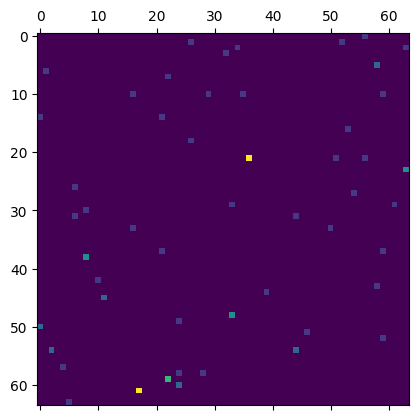

In [263]:
# vectorize the ligands


def mol2fp(mol):
    '''Molecule mapped to fingerprint'''
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     

# visualize one example fingerprint
fp = mol2fp(Chem.MolFromSmiles(ligands_df_CDK2_G1.loc[67,"Ligand SMILES"]))
print(fp)
plt.matshow(fp.reshape(64, -1), cmap="viridis")

In [264]:
# find all the different values in the fp array
np.unique(fp)

array([0, 1, 2, 3, 4, 6], dtype=int8)

We dont need to scale the input because the features are in the same range.

In [265]:
# Vectorize all the ligands
ligands_df_CDK2_G1["FPs"] = ligands_df_CDK2_G1.Molecule.apply(mol2fp)

[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerator
[21:42:52] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
# Stack fingerprints into a 2D numpy array
FP_ligands = np.stack(ligands_df_CDK2_G1['FPs'].values)
print(f"Fingerprint matrix shape: {FP_ligands.shape}")

Fingerprint matrix shape: (1131, 4096)


Adding both Morgan values and smiles properties :

In [ ]:
# Now adding new and other values


In [247]:
import sys
sys.path.append('src/scripts')  # Add the src folder to the Python path

from smiles_properties_rdkit import smiles_properties  # Import your function


In [248]:
# using Matilde's code
smiles_info = pd.DataFrame()

# add molecular information to the dataframe
smiles_info[['Molecular Weight', 'Donnors H', 'Acceptors H', 'Rings', 'Atoms', 'Single Bonds', 'Double Bonds', 'Triple Bonds', \
             'Charges', 'Ramification', 'Valence Electrons']] = ligands_df_CDK2_G1['Ligand SMILES'].apply(lambda x: pd.Series(smiles_properties(x)))

# count all different atoms present in the ligands
all_atoms = set()
for atom_counts in smiles_info['Atoms']:
    all_atoms.update(atom_counts.keys())

# make columns for every atom
for atom in sorted(all_atoms):  
    smiles_info[atom] = smiles_info['Atoms'].apply(lambda x: x.get(atom, 0))

In [249]:
smiles_info

,Molecular Weight,Donnors H,Acceptors H,Rings,Atoms,Single Bonds,Double Bonds,Triple Bonds,Charges,Ramification,Valence Electrons,Br,C,Cl,F,I,N,O,S
0,303.321,2,3,4,"{'C': 18, 'O': 2, 'N': 3}",7,2,0,"[(C, 0.015186919333622758), (C, 0.220766707443...",-3.21,112,0,18,0,0,0,3,2,0
1,317.348,2,3,4,"{'C': 19, 'O': 2, 'N': 3}",8,2,0,"[(C, 0.015186919333622758), (C, 0.220766707443...",-3.21,118,0,19,0,0,0,3,2,0
2,331.375,2,3,4,"{'C': 20, 'N': 3, 'O': 2}",9,2,0,"[(C, -0.06129413231164453), (C, -0.03074334889...",-3.21,124,0,20,0,0,0,3,2,0
3,345.402,2,3,4,"{'C': 21, 'N': 3, 'O': 2}",10,2,0,"[(C, -0.06506543812301023), (C, -0.05209837676...",-3.21,130,0,21,0,0,0,3,2,0
4,359.429,2,3,4,"{'C': 22, 'N': 3, 'O': 2}",11,2,0,"[(C, -0.06537107173165602), (C, -0.05585509853...",-3.21,136,0,22,0,0,0,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,423.416,1,6,3,"{'C': 19, 'O': 3, 'F': 3, 'N': 3, 'S': 1}",11,2,0,"[(C, 0.07754311448781437), (O, -0.496001842614...",-3.14,152,0,19,0,3,0,3,3,1
1127,473.423,1,6,3,"{'C': 20, 'O': 3, 'F': 5, 'N': 3, 'S': 1}",14,2,0,"[(C, 0.07754311448781437), (O, -0.496001842614...",-3.28,170,0,20,0,5,0,3,3,1
1128,473.423,1,6,3,"{'C': 20, 'O': 3, 'F': 5, 'N': 3, 'S': 1}",14,2,0,"[(C, 0.07754311448781437), (O, -0.496001842614...",-3.28,170,0,20,0,5,0,3,3,1
1129,455.433,1,6,3,"{'C': 20, 'O': 3, 'F': 4, 'N': 3, 'S': 1}",13,2,0,"[(C, 0.07754311448781437), (O, -0.496001842614...",-3.21,164,0,20,0,4,0,3,3,1


In [250]:
# Convert fingerprints to DataFrame
fingerprint_df = pd.DataFrame(
    ligands_df_CDK2_G1['Ligand SMILES'].apply(lambda x: mol2fp(Chem.MolFromSmiles(x))).tolist()
)

# Combine with molecular properties
combined_features = pd.concat([fingerprint_df, smiles_info], axis=1)


[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerator
[21:19:15] DEPRECATION WARNING: please use MorganGenerat

In [253]:
smiles_info.shape

(1131, 19)

In [252]:
fingerprint_df.shape

(1131, 4096)

In [251]:
combined_features

,0,1,2,3,4,5,6,7,8,9,...,Ramification,Valence Electrons,Br,C,Cl,F,I,N,O,S
0,0,0,0,0,0,0,0,0,0,0,...,-3.21,112,0,18,0,0,0,3,2,0
1,0,0,0,0,0,0,0,0,0,0,...,-3.21,118,0,19,0,0,0,3,2,0
2,0,0,0,0,0,0,0,0,0,0,...,-3.21,124,0,20,0,0,0,3,2,0
3,0,0,0,0,0,0,0,0,0,0,...,-3.21,130,0,21,0,0,0,3,2,0
4,0,0,0,0,0,0,0,0,0,0,...,-3.21,136,0,22,0,0,0,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,0,0,0,0,0,0,0,0,0,0,...,-3.14,152,0,19,0,3,0,3,3,1
1127,0,0,0,0,0,0,0,0,0,0,...,-3.28,170,0,20,0,5,0,3,3,1
1128,0,0,0,0,0,0,0,0,0,0,...,-3.28,170,0,20,0,5,0,3,3,1
1129,0,0,0,0,0,0,0,0,0,0,...,-3.21,164,0,20,0,4,0,3,3,1


In [212]:
# Stack the FPs
X = np.stack(ligands_df_CDK2_G1["FPs"].values)
y = np.log10(ligands_df_CDK2_G1["IC50 (nM)"].values)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1131, 4096)
y shape: (1131,)


Creating train, test & validation datasets from the given dataset.

In [213]:
y = y.reshape((-1,1))
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.10, random_state=42)

In [214]:
X_train.shape

(915, 4096)

In [215]:
# Normalizing output using standard scaling
# scaler = StandardScaler()
# y_train = scaler.fit_transform(y_train)
# y_test = scaler.transform(y_test)
# y_validation = scaler.transform(y_validation)

In [216]:
# Remove low variance features

feature_select = VarianceThreshold(threshold=0.1) #TODO: find the best threshold
X_train = feature_select.fit_transform(X_train)
X_validation = feature_select.transform(X_validation)
X_test = feature_select.transform(X_test)
X_train.shape

(915, 142)

In [217]:
# Let's get those arrays transfered to the GPU memory as tensors
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If you don't have a GPU, buy a graphics card. I have for a long time used a 1060 GTX, which is not that expensive anymore.
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()
X_train

cpu


tensor([[ 0.,  1.,  0.,  ...,  7.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  7.,  0.,  0.],
        [ 0.,  1.,  0.,  ...,  8.,  0.,  0.],
        ...,
        [ 0.,  1.,  0.,  ...,  4.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  7.,  0.,  0.],
        [ 0.,  0.,  0.,  ..., 11.,  0.,  0.]])

In [218]:
X_train.shape

torch.Size([915, 142])

In [219]:
# define the train and validation loader for the model
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=256,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=256,
                                          shuffle=False)

In [220]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        # Three layers and a output layer
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        #Layer normalization for faster training
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)        
        #LeakyReLU will be used as the activation function
        self.activation = nn.LeakyReLU()
        #Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):# Forward pass: stacking each layer together
        # Fully connected =&amp;gt; Layer Norm =&amp;gt; LeakyReLU =&amp;gt; Dropout times 3
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)
        #Final output layer
        out = self.fc_out(out)
        return out

In [221]:
# Defining the hyperparameters
input_size = X_train.size()[-1]     # The input size should fit our fingerprint size
hidden_size = 1024   # The size of the hidden layer
dropout_rate = 0.80    # The dropout rate
output_size = 1        # This is just a single task, so this will be one
learning_rate = 0.001  # The learning rate for the optimizer

# Defining the model
model = Net(input_size, hidden_size, dropout_rate, output_size)

In [222]:
model.cpu()

Net(
  (fc1): Linear(in_features=142, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.8, inplace=False)
)

In [223]:
# the loss
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [224]:
model.train() #Ensure the network is in "train" mode with dropouts active
epochs = 200
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pa
         
        output = model(fps) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        optimizer.step() # Optimize the weights
         
        running_loss += loss.item()
    else:
        if e%10 == 0:
            validation_loss = torch.mean(( y_validation - model(X_validation) )**2).item()
            print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(running_loss/len(train_loader)), validation_loss))


Epoch:   0 Training loss: 5.36 Validation loss: 1.87
Epoch:  10 Training loss: 1.36 Validation loss: 1.21
Epoch:  20 Training loss: 0.89 Validation loss: 0.88
Epoch:  30 Training loss: 0.65 Validation loss: 0.69
Epoch:  40 Training loss: 0.61 Validation loss: 0.53
Epoch:  50 Training loss: 0.53 Validation loss: 0.60
Epoch:  60 Training loss: 0.47 Validation loss: 0.46
Epoch:  70 Training loss: 0.48 Validation loss: 0.51
Epoch:  80 Training loss: 0.42 Validation loss: 0.57
Epoch:  90 Training loss: 0.41 Validation loss: 0.50
Epoch: 100 Training loss: 0.40 Validation loss: 0.41
Epoch: 110 Training loss: 0.37 Validation loss: 0.49
Epoch: 120 Training loss: 0.38 Validation loss: 0.42
Epoch: 130 Training loss: 0.32 Validation loss: 0.51
Epoch: 140 Training loss: 0.36 Validation loss: 0.45
Epoch: 150 Training loss: 0.30 Validation loss: 0.46
Epoch: 160 Training loss: 0.33 Validation loss: 0.51
Epoch: 170 Training loss: 0.32 Validation loss: 0.44
Epoch: 180 Training loss: 0.34 Validation loss

Now evaluate the model :

In [225]:
# Evaluate the model
model.eval() #Swith to evaluation mode, where dropout is switched off
y_pred_train = model(X_train)
y_pred_validation = model(X_validation)
y_pred_test = model(X_test)

In [226]:
# Test set loss
torch.mean(( y_test - y_pred_test )**2).item()

0.4313736855983734

In [227]:
# total sum of squares
tss = torch.sum((y_test - torch.mean(y_test))**2).item()
# residual sum of squares
rss = torch.sum((y_test - y_pred_test)**2).item()
# R2 score
r2 = 1 - rss/tss
print(f"R2 score: {r2}")

R2 score: 0.738944242389878


In [228]:
mae = torch.mean(torch.abs(y_test - y_pred_test)).item()
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 0.4514331519603729


In [229]:
mse = torch.mean((y_test - y_pred_test)**2).item()
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.4313736855983734


In [230]:
rmse = torch.sqrt(torch.mean((y_test - y_pred_test)**2)).item()
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.6567904353141785


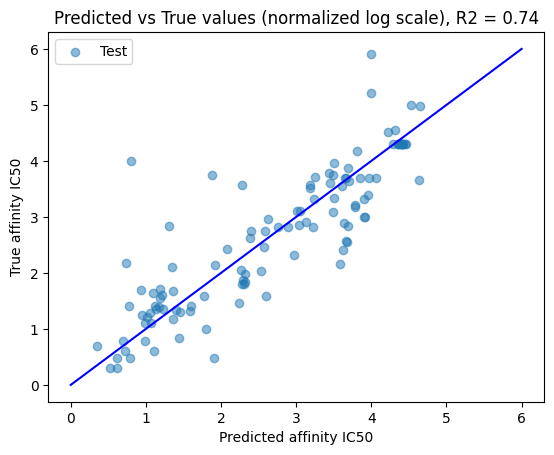

In [231]:
# make all tensors to numpy arrays
def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()

plt.scatter(flatten(y_pred_test), flatten(y_test), alpha=0.5, label="Test")
# plt.scatter(flatten(y_pred_train), flatten(y_train), alpha=0.1, label="Train")
plt.legend()
plt.title(f"Predicted vs True values (normalized log scale), R2 = {r2:.2f}")
plt.xlabel("Predicted affinity IC50")
plt.ylabel("True affinity IC50")
plt.plot([0, 6], [0, 6], c="b")
plt.show()

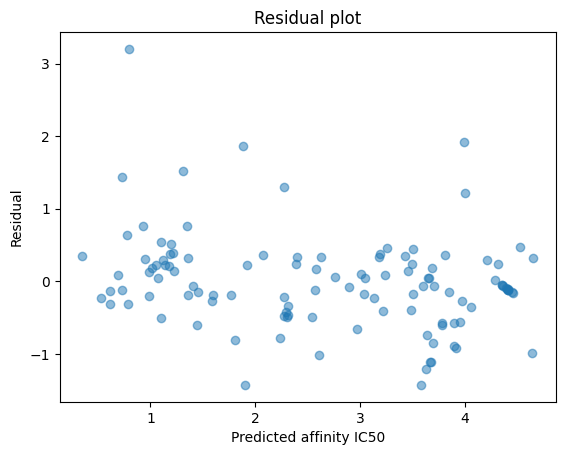

In [232]:
# Residual plot
plt.scatter(flatten(y_pred_test), flatten(y_test - y_pred_test), alpha=0.5)
plt.title("Residual plot")
plt.xlabel("Predicted affinity IC50")
plt.ylabel("Residual")
plt.show()

In [233]:
def predict_affinity(scaler, model, smiles):
    '''
    Predict the affinity of a ligand using the trained model

    Args:
       - model: the trained model
       - smiles: smiles string of the ligand

    Output:
       - prediction: the predicted affinity (IC50) in the log, normalized scale
    '''
    fp = mol2fp(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    fp = feature_select.transform(fp)
    print(fp.shape)
    fp = torch.tensor(fp, device=device).float()
    # print(fp.shape)
    prediction = model(fp)
    prediction = scaler.inverse_transform(prediction.cpu().detach().numpy())
   #  prediction = np.exp(prediction) # because of the log10
    return prediction

In [234]:
print(ligands_df_CDK2_G1[ligands_df_CDK2_G1["IC50_class"] == "weak"]["Ligand SMILES"][8])

CC(=O)Nc1cccc2-c3n[nH]c(c3C(=O)c12)-c1ccc(Oc2ccccc2)cc1


In [235]:
df_CDK[(df_CDK["IC50_class"] == "weak") & (df_CDK["Target Name"] != "Cyclin-dependent kinase 2/G1/S-specific cyclin-E1")]#.iloc[4]["Ligand SMILES"]

,Ligand SMILES,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,IC50 (nM),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,IC50_class,IC50 log
0,COc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Methoxyphenyl)-amino)-4-((3-chlorophenyl...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,5800.0,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,weak,8.665613
1,Oc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1,3-((4-Hydroxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,1000.0,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,weak,6.907755
2,COc1cccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)c1,3-((3-Methoxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,4300.0,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,weak,8.366370
3,Oc1cccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)c1,3-((3-Hydroxyphenyl)amino)-4-((3-chlorophenyl)...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,3000.0,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,weak,8.006368
4,CC(C)(C)OC(=O)Nc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl...,3-((4-(N-BOC-amino)phenyl)amino)-4-((3-chlorop...,Cyclin-dependent kinase/G2/mitotic-specific cy...,Homo sapiens,57000.0,MEDYTKIEKIGEGTYGVVYKGRHKTTGQVVAMKKIRLESEEEGVPS...,CDK1_HUMAN,weak,10.950807
...,...,...,...,...,...,...,...,...,...
7859,CCN(CC)C1CCN(CC1)c1ccc(Nc2ncc3cc4C(=O)NCC5(CCC...,"US9464092, LLL::US9527857, LLL",Cyclin-A1/Cyclin-dependent kinase 2,Homo sapiens,4530.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,8.418477
7861,CC1CN(CCN1CC1CC1)c1ccc(Nc2ncc3cc4C(=O)NCC5(CCC...,"US9464092, NNN::US9527857, NNN",Cyclin-A1/Cyclin-dependent kinase 2,Homo sapiens,1010.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,6.917706
7863,CC1CN(CCN1CCC(C)(C)C)c1ccc(Nc2ncc3cc4C(=O)NCC5...,"US9527857, PPP",Cyclin-A1/Cyclin-dependent kinase 2,Homo sapiens,2640.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,7.878534
7864,O=C1NCC2(CCCC2)n2c1cc1cnc(Nc3ccc(nn3)N3CCOCC3)...,"US10189849, Compound 33::US10927120, Compound ...",Cyclin-A1/Cyclin-dependent kinase 2,Homo sapiens,1880.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,7.539027


In [236]:
df_CDK[(df_CDK["IC50_class"] == "weak") & (df_CDK["Target Name"] == "Cyclin-dependent kinase 2/G1/S-specific cyclin-E1")]#.iloc[4]["Ligand SMILES"]

,Ligand SMILES,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,IC50 (nM),BindingDB Target Chain Sequence,UniProt (SwissProt) Entry Name of Target Chain,IC50_class,IC50 log
349,CC(=O)Nc1cccc2-c3n[nH]c(c3C(=O)c12)-c1ccc(Oc2c...,"3-(4-Phenoxyphenyl)-5-(acetamido)indeno[1,2-c]...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,2500.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,7.824046
380,CC(=O)Nc1cccc2-c3n[nH]c(C)c3C(=O)c12,"3-Methyl-5-(acetamido)indeno[1,2-c]pyrazol-4-o...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,11000.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,9.305651
381,CCc1[nH]nc2-c3cccc(NC(C)=O)c3C(=O)c12,"3-Ethyl-5-(acetamido)indeno[1,2-c]pyrazol-4-on...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,1500.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,7.313220
382,CCCc1[nH]nc2-c3cccc(NC(C)=O)c3C(=O)c12,"3-n-Propyl-5-(acetamido)indeno[1,2-c]pyrazol-4...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,3700.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,8.216088
385,CC(C)Cc1[nH]nc2-c3cccc(NC(C)=O)c3C(=O)c12,"3-Isobutyl-5-(acetamido)indeno[1,2-c]pyrazol-4...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,3500.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,8.160518
...,...,...,...,...,...,...,...,...,...
8172,CS(=N)(=O)Cc1cccc(Nc2ncnc(n2)-c2ccc(F)cc2OCC(F...,"US9669034, 95 (rac)-4-[2-(2,2-Difluoroethoxy)-...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,1800.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,7.495542
8182,CS(=N)(=O)Cc1cccc(Nc2ncnc(n2)-c2ccc(F)cc2OCCCC...,"US9669034, 100 (rac)-4-[4-Fluoro-2-(4,4,4-trif...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,1300.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,7.170120
8188,CS(=N)(=O)Cc1cccc(Nc2ncnc(n2)-c2ccc(F)cc2OCc2c...,"US9669034, 103 (rac)-4-{4-Fluoro-2-[(2,4,5-tri...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,1200.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,7.090077
8198,CCS(=N)(=O)Cc1cccc(Nc2ncnc(n2)-c2ccc(F)cc2OC)c1,"US9669034, 108 (rac)-N-{3-[(S-ethylsulfonimido...",Cyclin-dependent kinase 2/G1/S-specific cyclin-E1,Homo sapiens,1000.0,MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDTETEGVPS...,CDK2_HUMAN,weak,6.907755


In [237]:
def predict_affinity(model, smiles):
    '''
    Predict the affinity of a ligand using the trained model.

    Args:
       - scaler: the scaler used during training
       - model: the trained model
       - smiles: SMILES string of the ligand

    Output:
       - prediction: the predicted affinity (IC50) in the log scale, normalized
    '''
    fp = mol2fp(Chem.MolFromSmiles(smiles))

    print(fp)

    fp = feature_select.transform(fp.reshape(1,-1))

    pred = model(torch.tensor(fp, device=device).float())

    print(f"Predicted value log : {pred.item()}")
    # print(f"Prediction value (not log): {np.exp(pred.item())}")
    return pred


In [238]:
predict_affinity(model, "COc1ccc(Nc2[nH]nc3ncnc(Nc4cccc(Cl)c4)c23)cc1")

[0 0 0 ... 0 0 0]
Predicted value log : 4.482480049133301


[20:34:33] DEPRECATION WARNING: please use MorganGenerator


tensor([[4.4825]], grad_fn=<AddmmBackward0>)

Visualize the molecule structures! NB

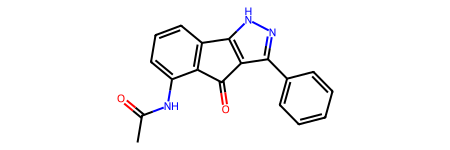

In [240]:
ligands_df_CDK2_G1.iloc[0]["Molecule"]